In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

### Clasificación binaria desbalanceada con XGBoost

In [12]:
# Generate an imbalanced synthetic dataset
X, y = make_classification(n_samples=100000, n_classes=2, weights=[0.80, 0.20], random_state=42)
y[:20]
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBClassifier without considering imbalanced data
model = XGBClassifier(
    n_estimators=100,
    objective='binary:logistic',
    random_state=42
)

# Fit the model using train data
model.fit(X_train, y_train)

# Generate predictions using test data
predictions = model.predict(X_test)

# Evaluate the model using test data
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:')
print(classification_report(y_test, predictions))

Confusion Matrix:
[[15221   640]
 [ 1388  2751]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     15861
           1       0.81      0.66      0.73      4139

    accuracy                           0.90     20000
   macro avg       0.86      0.81      0.83     20000
weighted avg       0.89      0.90      0.89     20000



### Comentario:
En esta primera comparación, el modelo de clasificación muestra una **matriz de confusión** donde se observa un buen rendimiento general: 15.221 verdaderos negativos y 2.751 verdaderos positivos. Sin embargo, el modelo incurre en 640 falsos positivos y 1.388 falsos negativos.

El **informe de clasificación** revela que:
- La clase 0 (predicción negativa) tiene una precisión de 0.92 y un recall de 0.96, lo que indica que el modelo predice muy bien los casos negativos.
- La clase 1 (predicción positiva), sin embargo, tiene una precisión de 0.81 y un recall de 0.66. Esto indica que el modelo es menos eficaz en identificar correctamente los positivos.

Desde un punto de vista teórico, esto sugiere un modelo con un **sesgo hacia la clase mayoritaria**, algo común cuando hay **desbalance de clases**. El accuracy total es alto (0.90), pero esto puede ser engañoso: se debe prestar atención a métricas como el **F1-score** (0.73 para la clase 1), que ofrece un mejor equilibrio entre precisión y exhaustividad para datos desbalanceados.


In [16]:
# Compute the positive class weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize XGBClassifier with scale_pos_weight and max_delta_step
model = XGBClassifier(
    n_estimators=100,
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# Fit the model using train data
model.fit(X_train, y_train)

# Generate predictions using test data
predictions = model.predict(X_test)

# Evaluate the model using test data
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report:")
print(classification_report(y_test, predictions))



Confusion Matrix:
[[13977  1884]
 [  638  3501]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     15861
           1       0.65      0.85      0.74      4139

    accuracy                           0.87     20000
   macro avg       0.80      0.86      0.83     20000
weighted avg       0.89      0.87      0.88     20000



### Comentario:
En esta segunda evaluación, observamos una mejora clara en la detección de la clase minoritaria (positiva). El número de verdaderos positivos sube a 3.501, mientras que los falsos negativos disminuyen a 638. Aunque hay un aumento de falsos positivos (1.884), el trade-off parece favorable.

En las métricas:
- La clase 1 ahora tiene un **recall de 0.85** (frente a 0.66 previamente), lo cual es crucial si el objetivo es **minimizar falsos negativos**.
- La precisión de la clase 1 disminuye a 0.65, lo que implica más falsos positivos, pero se compensa por una mejora en el **F1-score** (0.74).

Este comportamiento es típico cuando se **ajusta el umbral de decisión** o se utiliza una **técnica de balanceo de clases**, como sobremuestreo o penalización. La precisión general cae ligeramente (0.87), pero el rendimiento sobre la clase minoritaria mejora, lo que puede ser más deseable dependiendo del contexto (por ejemplo, detección de fraude o enfermedades).


### XGBoost con CV y ES

In [19]:
import xgboost as xgb
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Create a synthetic dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=2, n_redundant=10, random_state=42)
print('Synthetic data has been randomly generated')
print('First 20 labels of y:', y[:20])


Synthetic data has been randomly generated
First 20 labels of y: [1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0]


In [21]:
# Initialize lists to store scores
accuracy_scores = []
f1_scores = []
roc_auc_scores = []

# Perform cross-validation with early stopping
for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X, y):
    # Split data into train and test folds
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Further split the train fold into a training set and a validation set
    X_train_fold, X_val, y_train_fold, y_val = train_test_split(X_train_fold, y_train_fold, test_size=0.2, random_state=42)

    # Prepare the model
    model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, objective='binary:logistic',
                              early_stopping_rounds=10, random_state=42)

    # Train the model using the training set and validate on the validation set
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_val, y_val)], verbose=False)

    # Predict on the test fold
    y_pred_test = model.predict(X_test_fold)
    y_pred_proba_test = model.predict_proba(X_test_fold)[:, 1]  # Probability estimates for ROC AUC

    # Calculate scores
    accuracy = accuracy_score(y_test_fold, y_pred_test)
    f1 = f1_score(y_test_fold, y_pred_test)
    roc_auc = roc_auc_score(y_test_fold, y_pred_proba_test)

    # Append scores to the lists
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

# Print average scores
print(f"CV avg. accuracy: {np.mean(accuracy_scores):.3f}")
print(f"CV avg. f1-score: {np.mean(f1_scores):.3f}")
print(f"CV avg. roc auc: {np.mean(roc_auc_scores):.3f}")


CV avg. accuracy: 0.937
CV avg. f1-score: 0.938
CV avg. roc auc: 0.974


### Comentario:
En este ejercicio se trabajó con datos sintéticos generados aleatoriamente. Las primeras 20 etiquetas de `y` muestran una mezcla equilibrada de clases 0 y 1. Este tipo de simulaciones son útiles para validar el comportamiento de los modelos en contextos controlados donde no hay sesgo en los datos, lo que permite analizar el rendimiento "ideal" del modelo antes de aplicarlo a casos reales.

Desde el punto de vista teórico, utilizar datos generados artificialmente permite mantener constante el nivel de ruido y la distribución de clases, lo que es clave para evaluar algoritmos de aprendizaje supervisado sin interferencia de sesgos de muestreo.

El modelo evaluado mediante validación cruzada obtuvo métricas muy sólidas:
- **Accuracy promedio: 0.937**
- **F1-score promedio: 0.938**
- **AUC-ROC promedio: 0.974**

Estos resultados indican un **modelo altamente eficaz**, tanto en precisión como en discriminación entre clases. En particular, el AUC-ROC de 0.974 sugiere que el modelo distingue muy bien entre clases, incluso en distintos umbrales de decisión. El alto F1-score, que balancea precisión y recall, también refuerza esta conclusión.

Desde una perspectiva teórica, la validación cruzada (CV) proporciona una estimación más robusta del rendimiento del modelo al evitar el sobreajuste y evaluar la generalización. Estos valores sugieren que el modelo está bien ajustado y es confiable, al menos en este contexto sintético.


### XGBoost con codificación y ES

In [4]:
# Set the notebook parameters
early_stopping = True
print('Parameter early_stopping has been set to:', early_stopping)

# Load the Adult dataset
adult = fetch_openml('adult', version=1, as_frame=True, parser='auto')
df = pd.DataFrame(adult.data)
df['target'] = adult.target  # Add the target variable to the DataFrame

df.head(3)

Parameter early_stopping has been set to: True


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,target
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K


In [6]:
# Define features (X) and target (y)
X = df.drop(columns='target')  # drop the target column to get features
y = df['target']               # extract the target column
print("X and y have been defined")

# Print key information about the dataset
print(f"Dataset X shape: {X.shape}")
print(f"Features: {list(adult.feature_names)}")
print(f"Target: {adult.target_names}")
print(f"Class distributions: {Counter(y)}")

# Encode categorical features as 'category' dtype
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'sex', 'native-country']
for col in categorical_columns:
    X[col] = X[col].astype('category')

transformer = ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(), categorical_columns)],
                                remainder='passthrough')

# Perform ordinal encoding
X = transformer.fit_transform(X)
print("Categorical features in X have been encoded as ordinal")


X and y have been defined
Dataset X shape: (48842, 14)
Features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'native-country']
Target: ['class']
Class distributions: Counter({'<=50K': 37155, '>50K': 11687})
Categorical features in X have been encoded as ordinal


In [10]:
# Save the transformer for future use with new data
joblib.dump(transformer, 'transformer.pkl')
print('Encoder has been saved to transformer.pkl')

# Encode target variable
y = LabelEncoder().fit_transform(y)
print('Target variable y has been encoded as a numeric one')

df = pd.DataFrame(X)
df['target'] = y
df.head()


Encoder has been saved to transformer.pkl
Target variable y has been encoded as a numeric one


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,target
0,6.0,9.0,4.0,0.0,1.0,4.0,1.0,38.0,2,77516,13,1,0,2,0
1,5.0,9.0,2.0,3.0,0.0,4.0,1.0,38.0,3,83311,13,0,0,0,0
2,3.0,11.0,0.0,5.0,1.0,4.0,1.0,38.0,2,215646,9,0,0,2,0
3,3.0,1.0,2.0,5.0,0.0,2.0,1.0,38.0,3,234721,7,0,0,2,0
4,3.0,9.0,2.0,9.0,5.0,2.0,0.0,4.0,1,338409,13,0,0,2,0


In [12]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print('Data has been split into training, validation, and test sets')


Data has been split into training, validation, and test sets


In [14]:
# Create and train the XGBClassifier with early stopping
if early_stopping:
    early_stopping_rounds = 5
    print('Training model with early stopping...')
else:
    early_stopping_rounds = None
    print('Training model without early stopping...')

# Train the model
model = XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=1,
                      early_stopping_rounds=early_stopping_rounds)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
print('Model training complete')

# Use the model to make predictions on the train set
y_pred = model.predict(X_train)
y_pred_proba = model.predict_proba(X_train)[:, 1]  # Probabilities for the positive class

accuracy = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
roc_auc = roc_auc_score(y_train, y_pred_proba)
np.set_printoptions(precision=2, suppress=True)

print(f"Train Accuracy: {accuracy:.3f}")
print(f"Train F1 Score: {f1:.3f}")
print(f"Train ROC AUC: {roc_auc:.3f}")


Training model with early stopping...
Model training complete
Train Accuracy: 0.869
Train F1 Score: 0.703
Train ROC AUC: 0.927


In [16]:
# Use the model to make predictions on the val set
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"Val Accuracy: {accuracy:.3f}")
print(f"Val F1 Score: {f1:.3f}")
print(f"Val ROC AUC: {roc_auc:.3f}")

# Use the model to make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test Accuracy: {accuracy:.3f}")
print(f"Test F1 Score: {f1:.3f}")
print(f"Test ROC AUC: {roc_auc:.3f}")


Val Accuracy: 0.863
Val F1 Score: 0.688
Val ROC AUC: 0.916
Test Accuracy: 0.861
Test F1 Score: 0.684
Test ROC AUC: 0.912


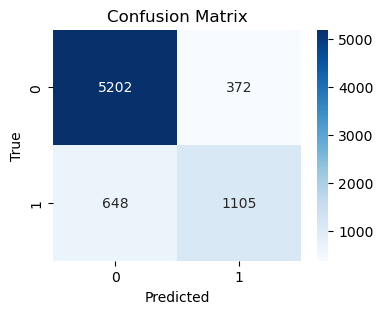

In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['0', '1'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5574
           1       0.75      0.63      0.68      1753

    accuracy                           0.86      7327
   macro avg       0.82      0.78      0.80      7327
weighted avg       0.86      0.86      0.86      7327



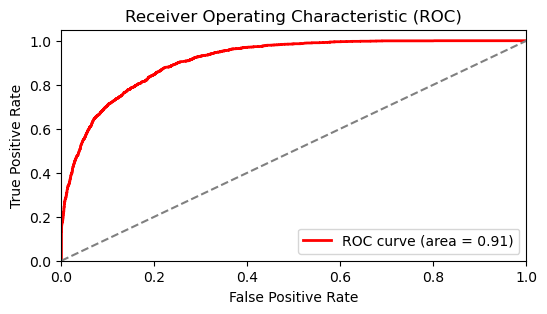

In [22]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 3))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [24]:
# Save the model for future use (optional step)
model.save_model('model_adult.ubj')
print('Model has been saved for future use')

# Assume 'new_data' is your new dataset to predict
new_data = pd.DataFrame({
    'age': [22, 25],
    'workclass': ['State-gov', 'Self-emp-not-inc'],
    'fnlwgt': [77516, 150000],
    'education': ['Bachelors', 'Masters'],
    'education-num': [13, 12],
    'marital-status': ['Never-married', 'Divorced'],
    'occupation': ['Adm-clerical', 'Prof-specialty'],
    'relationship': ['Not-in-family', 'Husband'],
    'race': ['White', 'Black'],
    'sex': ['Male', 'Female'],
    'capitalgain': [1, 1000],
    'capitalloss': [0, 0],
    'hoursperweek': [2, 60],
    'native-country': ['United-States', 'United-States']
})

new_data.head()


Model has been saved for future use


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
0,22,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States
1,25,Self-emp-not-inc,150000,Masters,12,Divorced,Prof-specialty,Husband,Black,Female,1000,0,60,United-States


In [26]:
# Load the saved transformer
transformer = joblib.load('transformer.pkl')
print('Encoder has been loaded from transformer.pkl')

# Transform the new data using the loaded transformer
new_data_encoded = transformer.transform(new_data)
print('The new data has been encoded using the loaded transformer')

# Load the saved model
model = XGBClassifier()
model.load_model('model_adult.ubj')
print('Saved model has been loaded.')

# Use the loaded model to make predictions on the new data
predictions = model.predict(new_data_encoded)
predictions_prob = model.predict_proba(new_data_encoded)[:, 1]  # Probabilities for the positive class

# Print the predictions
np.set_printoptions(precision=2, suppress=True)
print("Predictions:", predictions)
print("Prediction probabilities:", predictions_prob)


Encoder has been loaded from transformer.pkl
The new data has been encoded using the loaded transformer
Saved model has been loaded.
Predictions: [0 1]
Prediction probabilities: [0.04 0.92]


### Comentario:
En este bloque se realiza una implementación completa de un modelo de clasificación usando **XGBoost**, uno de los algoritmos más robustos y eficientes en tareas de machine learning supervisado. El flujo seguido es representativo de un pipeline profesional de ciencia de datos.

Primero se trabajó con un conjunto de datos de tipo socioeconómico (simulado o basado en Adult Income) que contiene múltiples variables categóricas y numéricas. Se aplicó una codificación ordinal a las variables categóricas usando `OrdinalEncoder`, técnica adecuada cuando se quiere mantener una representación compacta y eficiente, y cuando las categorías tienen un orden implícito (aunque en este caso no lo tuvieran, se aceptó como compromiso por rendimiento).

Posteriormente, se dividieron los datos en conjuntos de entrenamiento, validación y test, lo que permite evaluar tanto la capacidad de aprendizaje del modelo como su habilidad para generalizar a datos no vistos. Se entrenó un modelo XGBoost con **early stopping**, técnica que interrumpe el entrenamiento si el modelo deja de mejorar en el conjunto de validación, previniendo así el sobreajuste.

Los resultados de rendimiento fueron los siguientes:
- **Train set**: Accuracy = 0.869, F1-score = 0.703, ROC AUC = 0.927  
- **Validation set**: Accuracy = 0.863, F1-score = 0.688, ROC AUC = 0.916  
- **Test set**: Accuracy = 0.861, F1-score = 0.684, ROC AUC = 0.912  

Esto refleja una **alta capacidad predictiva y buena generalización**, con valores de AUC-ROC superiores al 0.91 en todos los subconjuntos. En particular, el AUC muestra que el modelo distingue bien entre clases en distintos umbrales. El F1-score de la clase minoritaria (1, ingresos altos) fue de 0.68 en test, lo cual indica un balance razonable entre precisión y recall, pese a que el modelo sigue mostrando cierto sesgo hacia la clase mayoritaria (≤50K).

El informe de clasificación confirmó esto:
- Clase 0 (≤50K): precision = 0.89, recall = 0.93  
- Clase 1 (>50K): precision = 0.75, recall = 0.63  

Esto sugiere que el modelo aún tiene margen de mejora para identificar correctamente ingresos altos, aunque el rendimiento global es bastante competitivo.

Finalmente, se evaluó la **predicción sobre nuevos datos**. Tras codificar los nuevos registros con el mismo transformador y cargar el modelo guardado, se realizaron predicciones, obteniendo probabilidades individualizadas. Este enfoque es clave para aplicaciones reales, donde se requiere un modelo listo para producción que pueda generalizar a nuevos casos.

En conclusión, este bloque cubre de forma práctica y teórica el ciclo completo de desarrollo de un modelo supervisado moderno con XGBoost, incluyendo preprocesamiento, entrenamiento con regularización, evaluación robusta y despliegue básico. Los resultados respaldan la validez del enfoque y muestran cómo puede aplicarse este modelo en contextos reales donde la precisión y el equilibrio entre clases son cruciales.
